## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix

## Data Preprocessing

In [2]:
onion = pd.read_csv("./Onion.csv")
onion.head()

,Commodity,Date,Arrivals in Qtls.,Min,Max,Modal
0,ONION,5/12/2015,158796,439,1538,1046
1,ONION,8/2/2015,37413,1789,3808,3054
2,ONION,10/23/2015,45384,1122,3035,2273
3,ONION,1/13/2016,271679,547,1468,1147
4,ONION,3/10/2016,261306,408,871,704


In [3]:
# let  the dataset sort with date
onion['Date'] = pd.to_datetime(onion['Date'])
onion = onion.sort_values(by='Date', ascending=True)
onion.set_index("Date", inplace=True)

In [4]:
onion = onion.drop(columns=['Commodity'])
print(onion.isnull().sum())

Arrivals in Qtls.    0
Min                  0
Max                  0
Modal                0
dtype: int64


In [5]:
onion.head()

,Arrivals in Qtls.,Min,Max,Modal
Date,,,,
2015-01-01,192433,633,1563,1126
2015-01-02,183317,612,1568,1147
2015-01-03,107223,476,1662,1140
2015-01-04,40997,545,1687,1125
2015-01-05,238692,560,1646,1211


## Exploratory Data Analysis

In [6]:
 onion.describe()

,Arrivals in Qtls.,Min,Max,Modal
count,1459.000000,1459.000000,1459.000000,1459.000000
mean,171309.672378,654.393420,1574.870459,1231.951337
std,93617.047022,448.739309,1015.756903,835.013776
min,238.000000,208.000000,593.000000,419.000000
25%,92269.500000,357.000000,859.000000,658.000000
50%,167555.000000,492.000000,1182.000000,924.000000
75%,238818.500000,749.000000,1869.000000,1455.000000
max,461343.000000,2844.000000,6401.000000,5102.000000


Data Overview

· Its contains a total of 1459 days records and includes 4 variables related to onion

Arrivals in Qtls.

    · Quantity of onions arriving in the market, measured in quintals
    · The average of quantity of onions is around 171309.67 quintals
    · The standard deviation is 93617.05 means that it has relatively high variability (coefficient of variation = 54.6%)
    · The range of quantity is from 238 to 461343
    · 25% of quantities below 92269.5, 50% of quantities are below 167555, 75% of quantities are price below 238818

Min

    · Minimum price observed for onions on the given date.
    · The average of minimum price of onions is 654.39
    · The standard deviation is 448.74 means that it has relatively high variability (coefficient of variation = 68.6%)
    · The range of minimum price is from 208 to 2844
    · 25% of prices are below 357, 50% of prices are below 492, 75% of prices are below 749

Max

    · Maximum price observed for onions on the given date.
    · The average of maximum price of onions is 1574.87
    · The standard deviation is 1015.76 means that it has relatively high variability (coefficient of variation = 64.5%)
    · The range of maximum price is from 593 to 6401
    · 25% of prices are prices below 859, 50% of prices are below 1182, 75% of prices are below 1869

Modal

    · Modal price of onions, representing the most frequently occurring price range.
    · The average of modal price of onions is 1231.95
    · The standard deviation is 835.01 means that it has relatively high variability (coefficient of variation = 67.8%)
    · The range of modal price is from 419 to 5102
    · 25% of prices are prices below 658, 50% of prices are below 924, 75% of prices are below 1455

In [7]:
onion.skew()

Arrivals in Qtls.    0.311434
Min                  2.065946
Max                  1.717423
Modal                1.840916
dtype: float64

The variables of Min, Max, and Modal have positive skewness and a long tail on the right side, which means that most are small, but sometimes, a few larger values pull up the distribution on the right side.

Even though the variable of Arrivals in Qtls, it also a positive skewness, but it is very close to the symmetric skewness (zero value)

In [8]:
onion.kurtosis()

Arrivals in Qtls.   -0.577818
Min                  4.600413
Max                  2.818059
Modal                3.356908
dtype: float64

The kurtosis value of Min is greater than 3, which means that it is leptokurtosis (have greater outlier potential).

For the Modal and Max variables, their kurtosis values are 3.357 and 2.818, respectively, which are near 3.0, meaning that their outlier characters are closely similar to that of the normal distribution.

For Arrivals in Qtls. it exhibit less kurtosis than a normal distribution because its kurtosis value is -0.578 which is less than 3.0

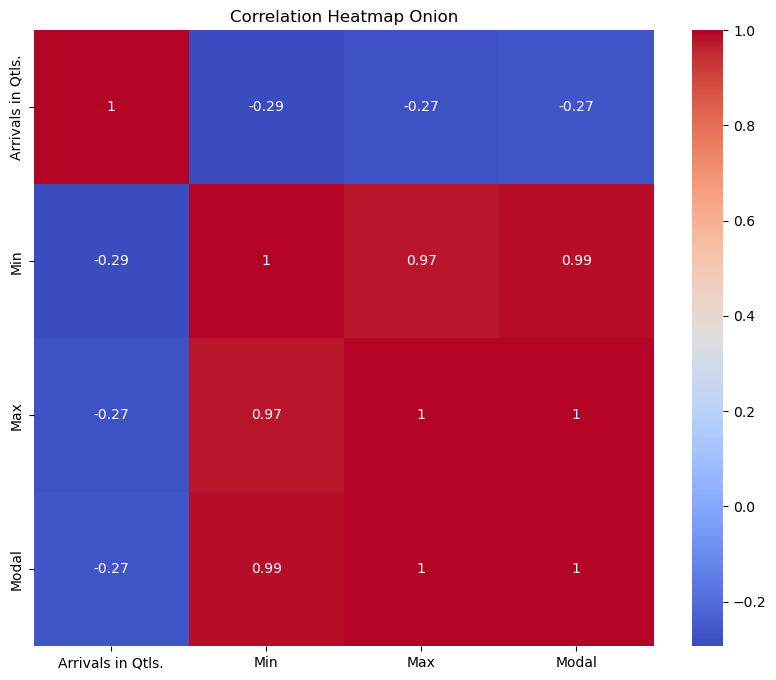

In [9]:
correlation_onion = onion.corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(correlation_onion, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap Onion')
plt.show()

Min, max, and model has the stronger postive relationship to each others

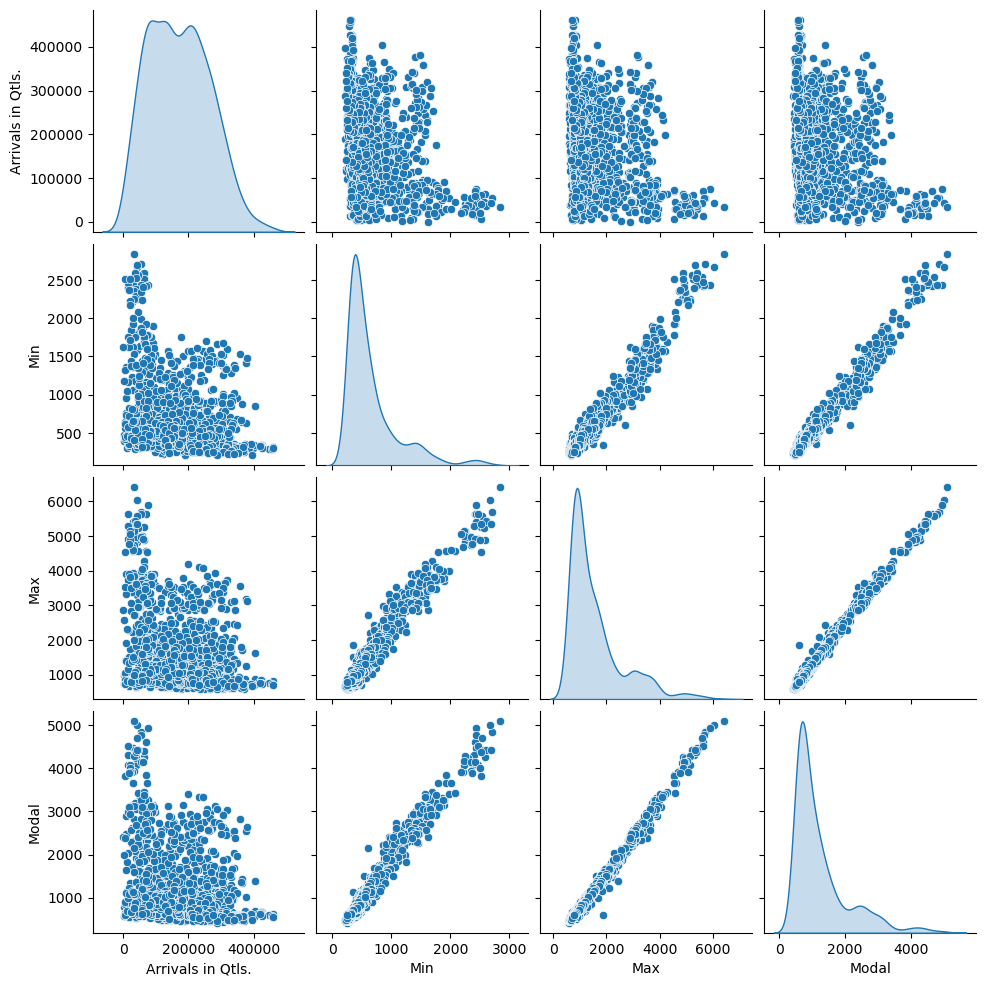

In [10]:
sns.pairplot(onion[['Arrivals in Qtls.', 'Min', 'Max', 'Modal']], diag_kind='kde')
plt.show()

The diagonal elements are kernal density estimation plots showing the distribution of individual variables

    · The min, max, model variables seem to have a skewed distribution while the arrivals in qtls is more densely distributed in the middle ranges

The off diagonal elements are showing pairwise relationships between variables

    · For the min, max, and modal, the scatter plot shows a strong positive correlation among themselves
    · However, the arrivals in qtls seem to have no obvious linear correlation or strong relationship with other variables that emerged.

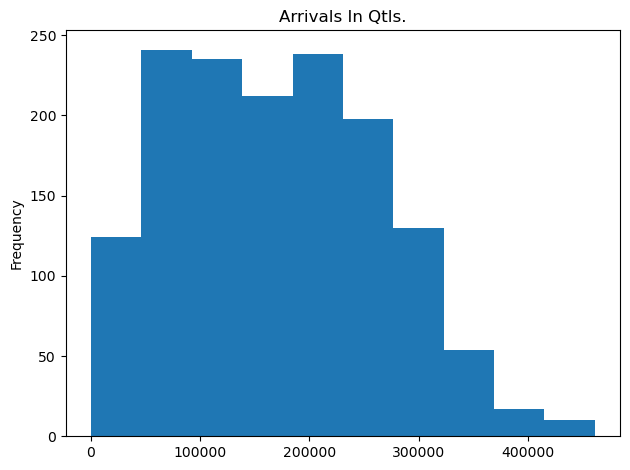

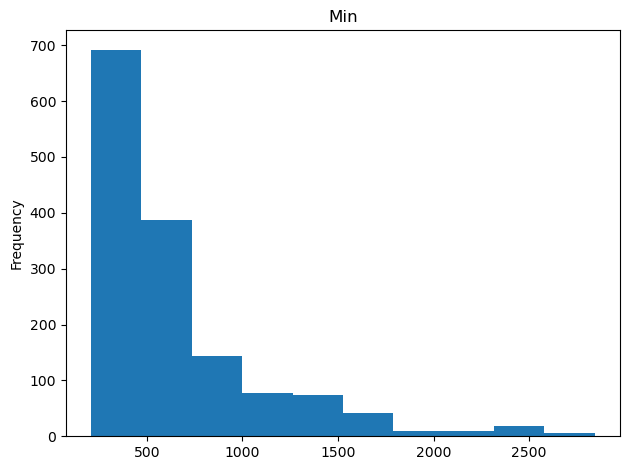

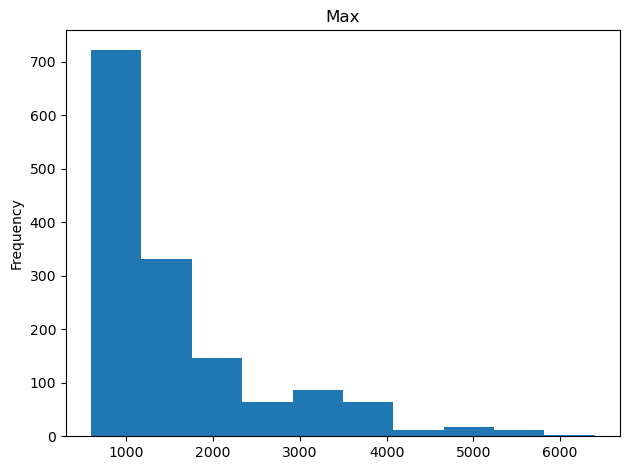

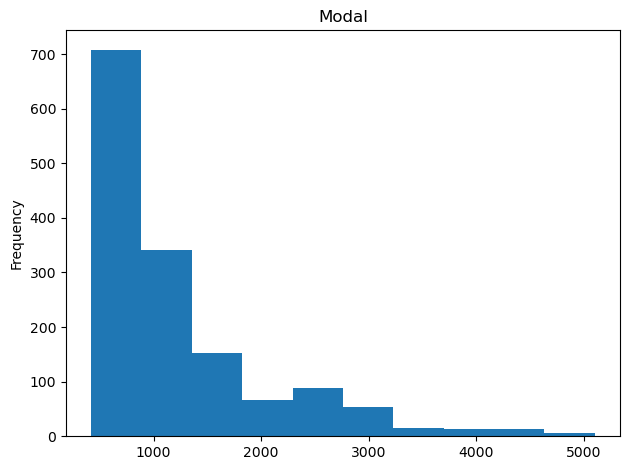

In [11]:
def histogram_plot(x, title):
    plt.hist(x)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

columns_to_plot_onion = ['Arrivals in Qtls.', 'Min', 'Max', 'Modal']
for col in columns_to_plot_onion:
  histogram_plot(onion[col], title=f"{col.replace('_', ' ').title()}")


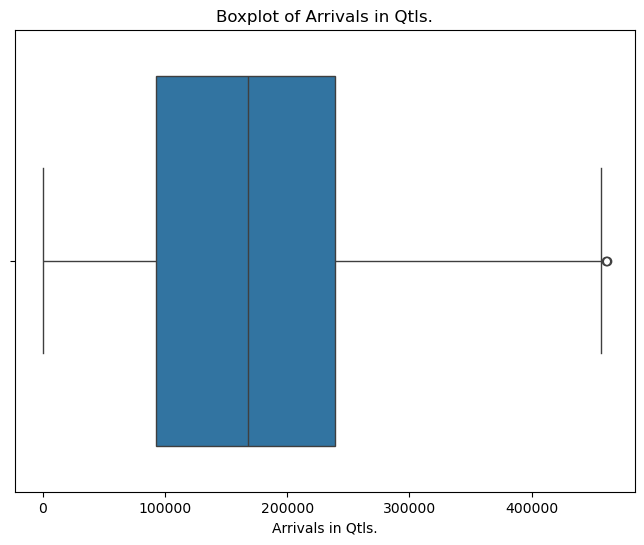

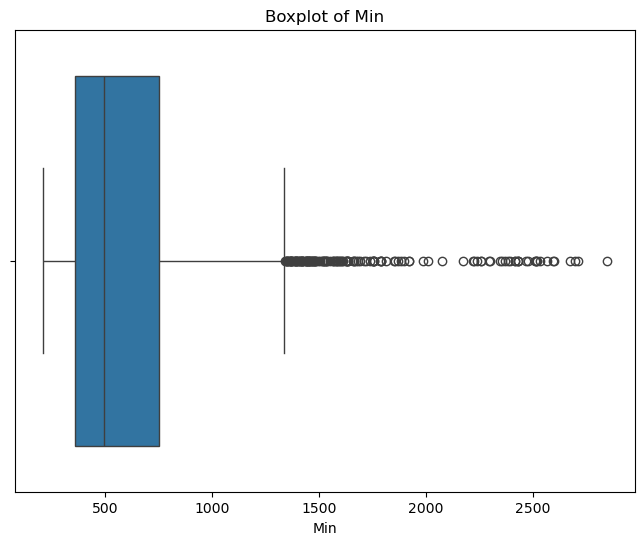

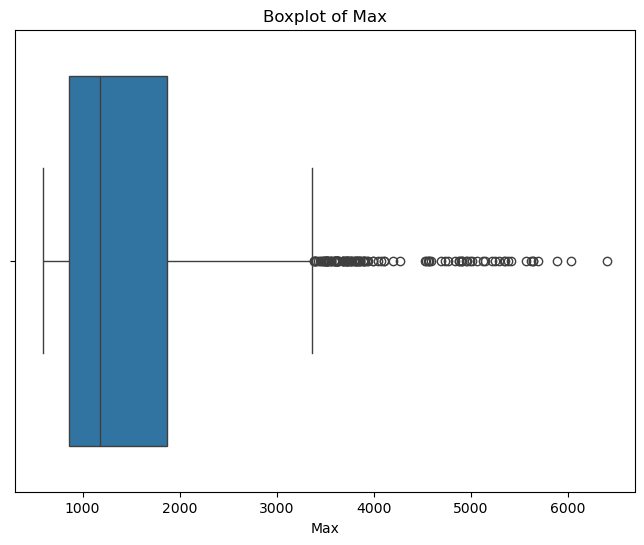

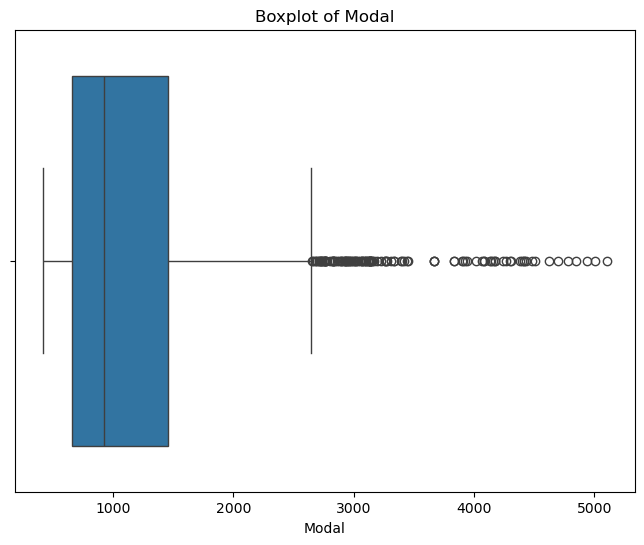

In [12]:
columns_to_plot_onion = ['Arrivals in Qtls.', 'Min', 'Max', 'Modal']
for col in columns_to_plot_onion:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=onion[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

Analysis

    · In arrivals in qtls has been obeserved some outliers and show that it could have the rare and extreme cases

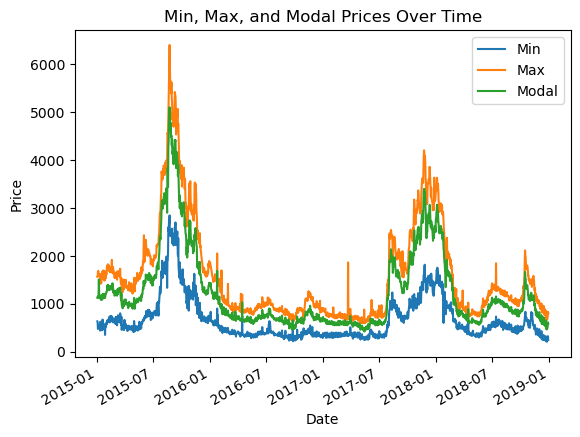

In [13]:
onion.plot(y=['Min', 'Max', 'Modal'])
plt.title("Min, Max, and Modal Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(['Min', 'Max', 'Modal'])
plt.show()

From January 2016 to January 2019, the onion price (maximum, minimum, and modal) display noticeable fluctuations

There has a significant price spike occurs arond mid-2018, shows the increased of demand

The minimum price is generally stable but has occasional dips, the maximum price may have the potential seasonal effects, and the trends of the model price closely with the minimum and maximum prices.

<Figure size 1500x800 with 0 Axes>

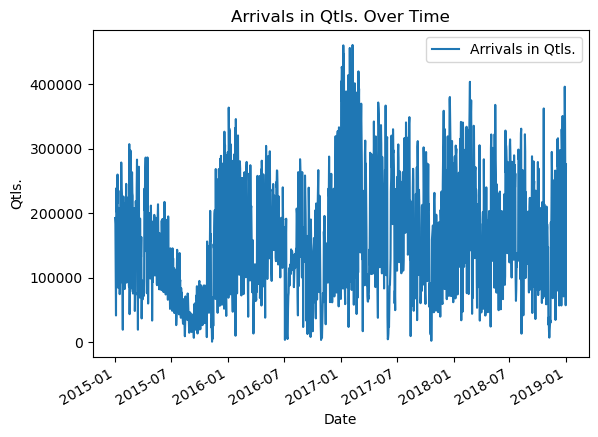

In [14]:
plt.figure(figsize=(15,8))
onion.plot(y='Arrivals in Qtls.')
plt.title("Arrivals in Qtls. Over Time")
plt.xlabel("Date")
plt.ylabel("Qtls.")
plt.show()

It has significant fluctuations over time, with recurring peaks and troughs

The peak level reached around early 2017, and the low levels dropped in late 2016, late 2017, and mid-2018

## Inferential Analysis

### Anova

In [15]:
model_1 = ols('Q("Modal") ~ Q("Arrivals in Qtls.")', data=onion).fit()
anova_table_1 = sm.stats.anova_lm(model_1, typ=2)
anova_table_1

# variation in Modal that can be explained by Arrivals in Qtls. price is 7.306e+07
# there is about 9.435e+08 of Modal explain the variance of Arrivals in Qtls. in relative to residuals
# because p value < 0.05, so it is the statistically significant in Modal across different min price, so need to do tukey test

,sum_sq,df,F,PR(>F)
"Q(""Arrivals in Qtls."")",7.305833e+07,1.0,112.816831,1.960701e-25
Residual,9.435293e+08,1457.0,NaN,NaN


In [16]:
tukey_preparation = pairwise_tukeyhsd(onion['Modal'], onion['Arrivals in Qtls.'])

with open("tukey_results(Modal_QTY).txt", "w") as file:
    file.write("Tukey's HSD Test Results:")
    file.write(str(tukey_preparation))

# All don't have statistically significant because of the p-value < 0.05
# The ANOVA analysis shows Arrivals in Qtls. has a statistically significant impact on Modal but the result of Tukey test shows that it doesn't have any effects
# Hence there is no effect between Arrivals in Qtls. and Modal

C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
model_2 = ols('Q("Modal") ~ Q("Min")', data=onion).fit()
anova_table_2 = sm.stats.anova_lm(model_2, typ=2)
anova_table_2

# variation in Modal that can be explained by Min price is 9.864e+08
# there is about 3.017e+07 of Modal explain the variance of Min in relative to residuals
# because p value < 0.05, so it is the statistically significant in Modal across different min price, so need to do tukey test

,sum_sq,df,F,PR(>F)
"Q(""Min"")",9.864151e+08,1.0,47632.95083,0.0
Residual,3.017253e+07,1457.0,NaN,NaN


In [18]:
tukey_preparation = pairwise_tukeyhsd(onion['Modal'], onion['Min'])

with open("tukey_results(Modal_Min).txt", "w") as file:
    file.write("Tukey's HSD Test Results:")
    file.write(str(tukey_preparation))

In [19]:
model_3 = ols('Q("Modal") ~ Q("Max")', data=onion).fit()
anova_table_3 = sm.stats.anova_lm(model_3, typ=2)
anova_table_3

# variation in Modal that can be explained by Max price is 1.008e+09
# there is about 8.929e+06 of Modal explain the variance of Max in relative to residuals
# because p value < 0.05, so it is the statistically significant in Modal across different min price, so need to do tukey test

,sum_sq,df,F,PR(>F)
"Q(""Max"")",1.007658e+09,1.0,164423.248489,0.0
Residual,8.929141e+06,1457.0,NaN,NaN


In [20]:
tukey_preparation = pairwise_tukeyhsd(onion['Modal'], onion['Max'])

with open("tukey_results(Modal_Max).txt", "w") as file:
    file.write("Tukey's HSD Test Results:")
    file.write(str(tukey_preparation))

Arrivals in Qtls.

    · variation in modal that can be explain by Arrivals in Qtls. is 1.31e+05
    · there is about 5.7e+07 of modal explain the variance of Arrivals in Qtls. in relative to residuals
    · because p value > 0.05, so it does not the statistically significant in modal across different Arrivals in Qtls.

Arrivals in Qtls.

    · variation in modal that can be explain by Arrivals in Qtls. is 1.31e+05
    · there is about 5.7e+07 of modal explain the variance of Arrivals in Qtls. in relative to residuals
    · because p value > 0.05, so it does not the statistically significant in modal across different Arrivals in Qtls.

Min

    · variation in modal that can be explain by min price is 5.59e+07
    · there is about 1.27e+06 of modal explain the variance of Min in relative to residuals
    · because p value < 0.05, so it is the statistically significant in modal across different min price, so need to do tukey test
    · TUKEY TEST
         ~ half of the part does not have the statistically sigificant while another part have the statistically significant because of the p-value < 0.05
    · The ANOVA analysis shows that min has a statistically significant impact on modal, the result of Tukey test show that the effect is present in a half of the groups.
    · Hence the effect of min on modal is relatively big but not for all

Max

    · variation in modal that can be explain by max price is 5.69e+07
    · there is about 1.82e+05 of modal explain the variance of max in relative to residuals
    · because p value < 0.05, so it is the statistically significant in modal across different max price, so need to do tukey test
    · TUKEY TEST
         ~ half of the part does not have the statistically sigificant while another part have the statistically significant because of the p-value < 0.05
    · The ANOVA analysis shows that max has a statistically significant impact on modal, the result of Tukey test show that the effect is present in a half of the groups.
    · Hence the effect of max on modal is relatively big but not for all

## ARIMA

In [6]:
onion = onion.drop(['Min', 'Max', 'Arrivals in Qtls.'], axis=1)
onion.head()

,Modal
Date,
2015-01-01,1126
2015-01-02,1147
2015-01-03,1140
2015-01-04,1125
2015-01-05,1211


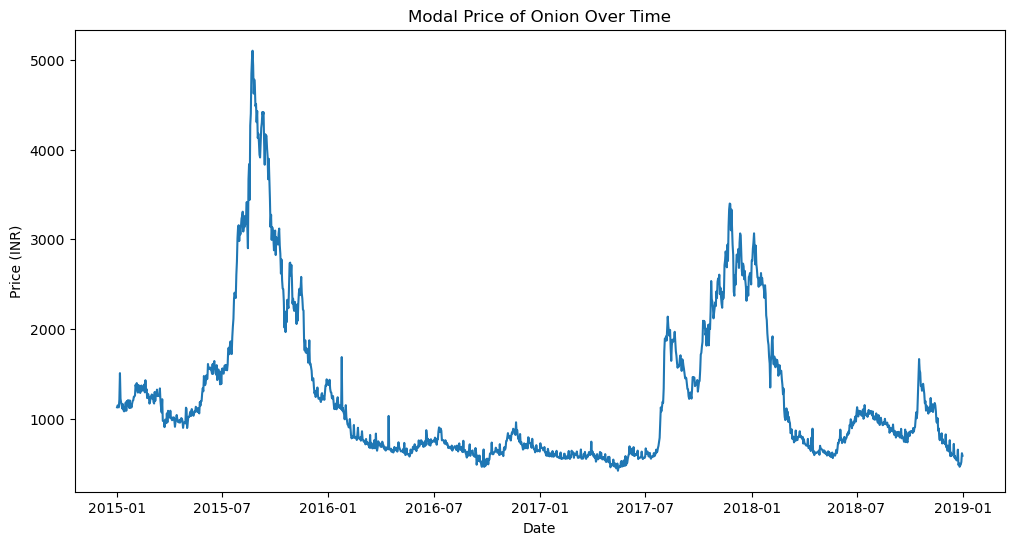

In [7]:
plt.figure(figsize=(12,6))
plt.plot(onion)
plt.title("Modal Price of Onion Over Time")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.show()

In [8]:
# Resample to weekly frequency
onion1 = onion.resample('W').mean()

# Smooth the data using a rolling window (4-week moving average)
onion_week = onion1.rolling(window=4).mean()

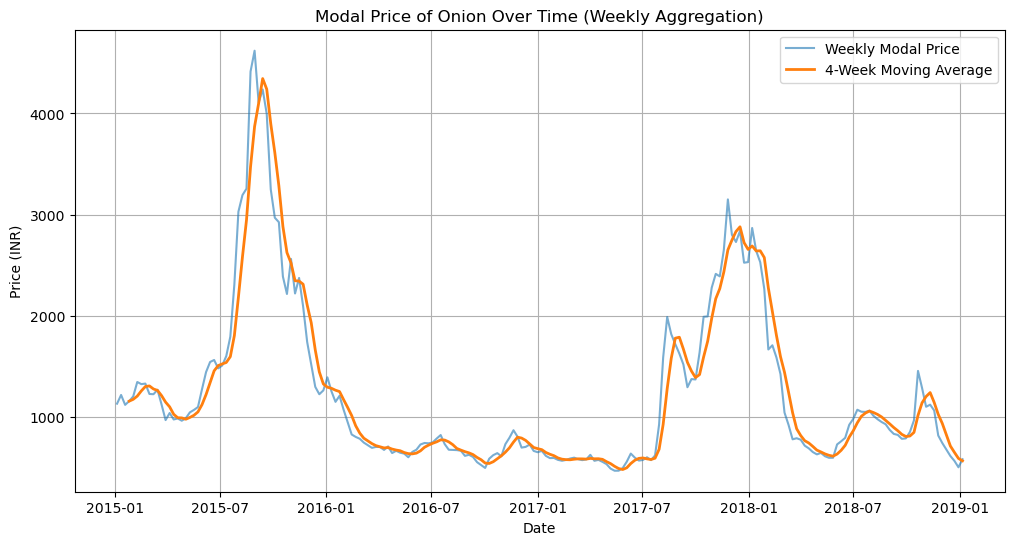

In [9]:
# Visualise the trend after resample and smoothing
plt.figure(figsize=(12,6))
plt.plot(onion1, label='Weekly Modal Price', alpha=0.6)
plt.plot(onion_week, label='4-Week Moving Average', linewidth=2)
plt.title("Modal Price of Onion Over Time (Weekly Aggregation)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid()
plt.show()

### Differencing

In [10]:
adf_test = adfuller(onion1)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -2.7849078215295435
p-value: 0.06046212700467262
Critical Values: {'1%': -3.4626576734812318, '5%': -2.8757444215841326, '10%': -2.5743412314098753}


In [11]:
onion_diff = onion1.diff().dropna()
adf_test = adfuller(onion_diff)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -5.913409413871169
p-value: 2.6065426696751397e-07
Critical Values: {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}


In [12]:
onion_diff.index = pd.date_range(start=onion_diff.index[0], periods=len(onion_diff), freq='W')

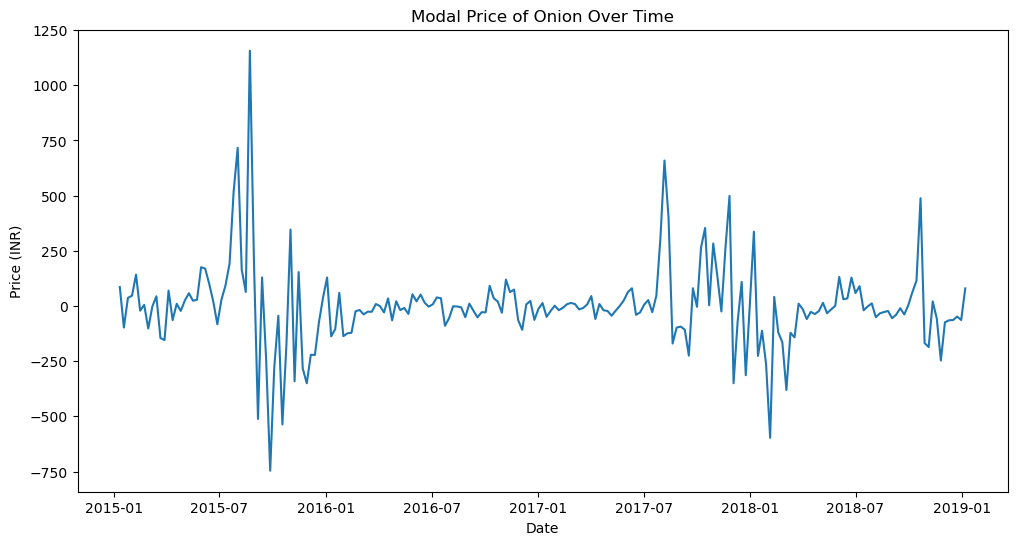

In [13]:
plt.figure(figsize=(12,6))
plt.plot(onion_diff)
plt.title("Modal Price of Onion Over Time")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.show()

### Arima Model

Text(0.5, 1.0, 'PACF for Onion Quantity')

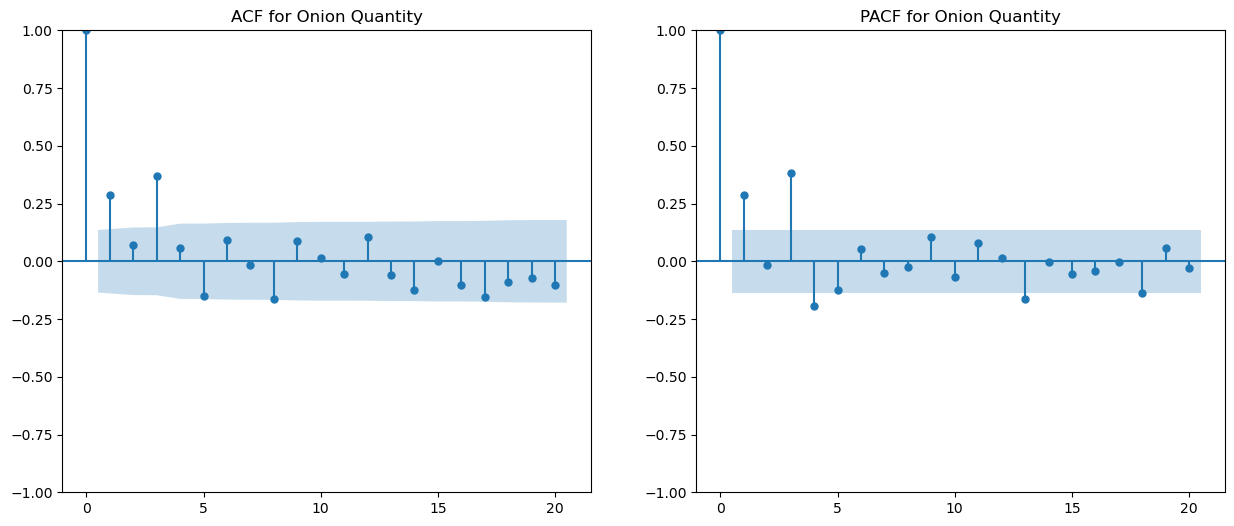

In [14]:
# Plot ACF and PACF for differenced data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(onion_diff, ax=axes[0], lags=20)
plot_pacf(onion_diff, ax=axes[1], lags=20)
axes[0].set_title("ACF for Onion Quantity")
axes[1].set_title("PACF for Onion Quantity")

In [15]:
# Calculate the 95% confidence internal threshold
n = len(onion_diff)
threshold = 1.96 / np.sqrt(n) # 1.96 = 95% confidence level (Z-score)
pacf_values = pacf(onion_diff, nlags=20)
acf_values = acf(onion_diff, nlags=20)

# Count significnat values for p (PACF)
significant_p_values = sum(abs(pacf_values[1:]) > threshold)
significant_q_values = sum(abs(acf_values[1:]) > threshold)

print(f"Number of significant p values (PACF): {significant_p_values}")
print(f"Number of significant q values (ACF): {significant_q_values}")

Number of significant p values (PACF): 5
Number of significant q values (ACF): 5


In [16]:
train_size = int(len(onion_diff) * 0.8)
train, test = onion_diff[:train_size], onion_diff[train_size:]

In [17]:
p = 5
d = 1
q = 5

In [18]:
model = ARIMA(train, order=(p, d, q))
arima_fit = model.fit()

C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Modal   No. Observations:                  167
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1090.266
Date:                Thu, 05 Dec 2024   AIC                           2202.532
Time:                        00:20:21   BIC                           2236.763
Sample:                    01-11-2015   HQIC                          2216.426
                         - 03-18-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7066      0.239     -7.151      0.000      -2.174      -1.239
ar.L2         -1.3386      0.402     -3.330      0.001      -2.127      -0.551
ar.L3          0.0507      0.354      0.143      0.886      -0.643       0.745
ar.L4          0.6424      0.211      3.045      0.002       0.229       1.056
ar.L5          0.4519      0.141      3.213      0.001       0.176       0.728
ma.L1          1.1378      5.877      0.194      0.846     -10.381      12.657
ma.L2         -0.0160     12.576     -0.001      0.999     -24.665      24.633
ma.L3         -1.1825     12.453     -0.095      0.924     -25.590      23.225
ma.L4         -0.7531      5.490     -0.137      0.891     -11.514      10.008
ma.L5         -0.1856      1.075     -0.173      0.863      -2.292       1.921
sigma2      3.486e+04   2.04e+05      0.171      0.865   -3.66e+05    4.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               245.63
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.60
Prob(H) (two-sided):                  0.39   Kurtosis:                         8.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
predictions = arima_fit.predict(start=test.index[0], end=test.index[-1])

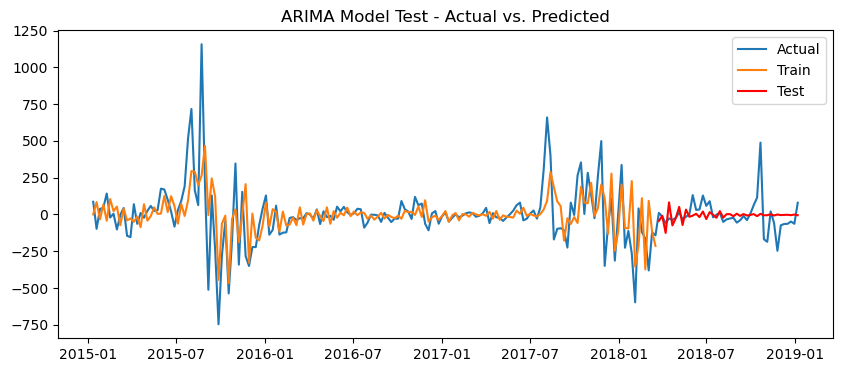

In [21]:
# Plot the actual vs. predicted values on the validation set
plt.figure(figsize=(10,4))
plt.plot(onion_diff['Modal'], label='Actual')
plt.plot(arima_fit.fittedvalues, label='Train')
plt.plot(predictions, color='red', label='Test')
plt.title('ARIMA Model Test - Actual vs. Predicted')
plt.legend()
plt.show()

In [25]:
rmse = np.sqrt(mean_squared_error(test['Modal'], predictions))
print('RMSE:', rmse)

mae = mean_absolute_error(test['Modal'], predictions)
print('MAE:', mae)

mape = mean_absolute_percentage_error(test['Modal'], predictions)
print('MAPE:', mape)

RMSE: 107.63088414629762
MAE: 69.39179362536747
MAPE: 2.3182230962061503


#### Forecast

In [26]:
# Forecast the rest 50 weeks
forecast_steps = 50
forecast_index = pd.date_range(onion1.index[-1], periods=forecast_steps, freq='W')
forecast = arima_fit.get_forecast(steps=forecast_steps, index=forecast_index)
forecast_diff = forecast.predicted_mean

# Get the last observed value from the original (non-differenced) data
last_value = onion1.iloc[-1]

# Reverse the diffencing
predicted_values = forecast_diff.cumsum() + last_value.iloc[0]

# Print the predicted values
print(predicted_values)

2019-01-06    541.913528
2019-01-13    532.696594
2019-01-20    407.382083
2019-01-27    489.562222
2019-02-03    415.246606
2019-02-10    391.083496
2019-02-17    442.513330
2019-02-24    370.690113
2019-03-03    403.808521
2019-03-10    388.143024
2019-03-17    380.234198
2019-03-24    384.697299
2019-03-31    366.900703
2019-04-07    387.013410
2019-04-14    355.789554
2019-04-21    371.756176
2019-04-28    369.120182
2019-05-05    346.752190
2019-05-12    369.507554
2019-05-19    347.838902
2019-05-26    349.959055
2019-06-02    352.152014
2019-06-09    340.193816
2019-06-16    345.350133
2019-06-23    335.449979
2019-06-30    338.416111
2019-07-07    331.389224
2019-07-14    328.029080
2019-07-21    330.502764
2019-07-28    319.066050
2019-08-04    323.141006
2019-08-11    317.499124
2019-08-18    312.375612
2019-08-25    313.861490
2019-09-01    306.559100
2019-09-08    306.202085
2019-09-15    302.032726
2019-09-22    299.106955
2019-09-29    296.855743
2019-10-06    292.085269


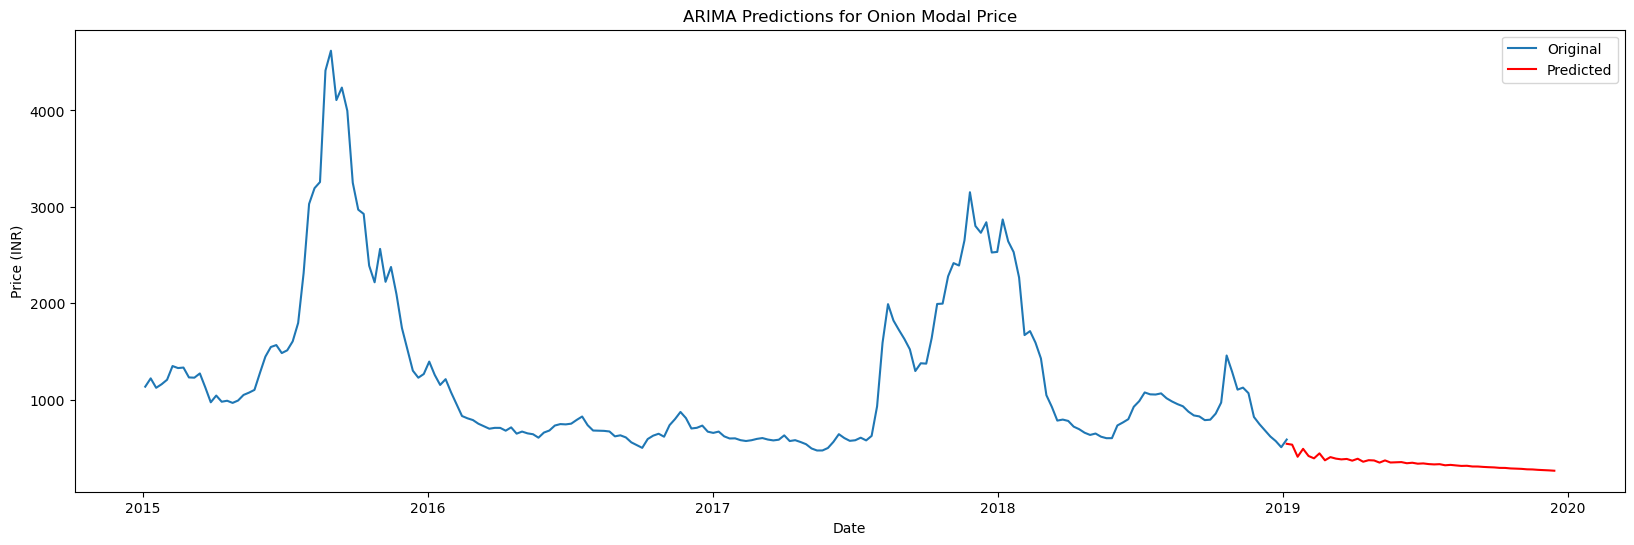

In [27]:
# Plot the original series
plt.figure(figsize=(20,6))
plt.plot(onion1['Modal'], label='Original')

# Plot the predicted values
plt.plot(predicted_values, color='red', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.title('ARIMA Predictions for Onion Modal Price')
plt.legend()
plt.show()

In [28]:
# Define parameter grid
p_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
d = 1
q_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_size = int(len(onion_diff) * 0.8)
train_data, test_data = onion_diff[:train_size], onion_diff[train_size:]

# Initialize variables to track the best models
best_aic = np.inf
best_order = None

# Perform grid search
for p in p_values:
    for q in q_values:
        order = (p, d, q)
        try:
            # Fit ARIMA model
            model = ARIMA(train_data, order=order)
            model_fit = model.fit()

            # Get AIC
            aic = model_fit.aic
            print(f"Order {order} - AIC: {aic:.3f}")

            # Update best AIC
            if aic < best_aic:
                best_aic = aic
                best_order = order

        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue

# Print the best models based on AIC
print(f"\nBest ARIMA Order by {best_order} with AIC: {best_aic:.3f}")

Order (1, 1, 1) - AIC: 2234.029
Order (1, 1, 2) - AIC: 2224.991
Order (1, 1, 3) - AIC: 2226.537
Order (1, 1, 4) - AIC: 2210.000
Order (1, 1, 5) - AIC: 2209.698
Order (1, 1, 6) - AIC: 2211.336
Order (1, 1, 7) - AIC: 2212.816


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (1, 1, 8) - AIC: 2209.790


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (1, 1, 9) - AIC: 2205.600


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (1, 1, 10) - AIC: 2198.804
Order (2, 1, 1) - AIC: 2218.022
Order (2, 1, 2) - AIC: 2219.755
Order (2, 1, 3) - AIC: 2211.862


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (2, 1, 4) - AIC: 2212.518
Order (2, 1, 5) - AIC: 2206.907


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (2, 1, 6) - AIC: 2198.526


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (2, 1, 7) - AIC: 2201.930


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (2, 1, 8) - AIC: 2200.174


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (2, 1, 9) - AIC: 2203.375


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (2, 1, 10) - AIC: 2202.393
Order (3, 1, 1) - AIC: 2220.005
Order (3, 1, 2) - AIC: 2205.476
Order (3, 1, 3) - AIC: 2201.761


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (3, 1, 4) - AIC: 2203.233


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (3, 1, 5) - AIC: 2202.860


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (3, 1, 6) - AIC: 2199.871


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (3, 1, 7) - AIC: 2203.235


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (3, 1, 8) - AIC: 2202.184


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (3, 1, 9) - AIC: 2204.853


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (3, 1, 10) - AIC: 2204.535
Order (4, 1, 1) - AIC: 2202.388


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (4, 1, 2) - AIC: 2203.260
Order (4, 1, 3) - AIC: 2202.772


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (4, 1, 4) - AIC: 2205.746


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (4, 1, 5) - AIC: 2205.458


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (4, 1, 6) - AIC: 2201.904


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (4, 1, 7) - AIC: 2203.467


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (4, 1, 8) - AIC: 2201.465


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (4, 1, 9) - AIC: 2204.614


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (4, 1, 10) - AIC: 2206.347
Order (5, 1, 1) - AIC: 2202.534


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (5, 1, 2) - AIC: 2204.063


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (5, 1, 3) - AIC: 2203.272


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (5, 1, 4) - AIC: 2195.741


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (5, 1, 5) - AIC: 2202.532


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (5, 1, 6) - AIC: 2201.599


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (5, 1, 7) - AIC: 2203.796


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (5, 1, 8) - AIC: 2201.340


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (5, 1, 9) - AIC: 2203.052


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (5, 1, 10) - AIC: 2203.696
Order (6, 1, 1) - AIC: 2203.882
Order (6, 1, 2) - AIC: 2206.530


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (6, 1, 3) - AIC: 2195.105


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (6, 1, 4) - AIC: 2197.355


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (6, 1, 5) - AIC: 2201.052


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (6, 1, 6) - AIC: 2204.235


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (6, 1, 7) - AIC: 2205.380


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (6, 1, 8) - AIC: 2201.322


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (6, 1, 9) - AIC: 2200.932


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (6, 1, 10) - AIC: 2200.849
Order (7, 1, 1) - AIC: 2205.831
Order (7, 1, 2) - AIC: 2207.020


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive par

Order (7, 1, 3) - AIC: 2198.698


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (7, 1, 4) - AIC: 2200.678


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (7, 1, 5) - AIC: 2203.035


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (7, 1, 6) - AIC: 2205.344


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (7, 1, 7) - AIC: 2204.671


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (7, 1, 8) - AIC: 2203.706


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (7, 1, 9) - AIC: 2213.925


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (7, 1, 10) - AIC: 2213.380


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (8, 1, 1) - AIC: 2207.717


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (8, 1, 2) - AIC: 2207.733


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (8, 1, 3) - AIC: 2198.708


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (8, 1, 4) - AIC: 2201.897


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (8, 1, 5) - AIC: 2204.715


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (8, 1, 6) - AIC: 2206.531


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (8, 1, 7) - AIC: 2205.767


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (8, 1, 8) - AIC: 2202.876


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (8, 1, 9) - AIC: 2212.267


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (8, 1, 10) - AIC: 2215.685
Order (9, 1, 1) - AIC: 2207.003


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (9, 1, 2) - AIC: 2207.759


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (9, 1, 3) - AIC: 2199.178


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (9, 1, 4) - AIC: 2201.896


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (9, 1, 5) - AIC: 2205.862


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (9, 1, 6) - AIC: 2207.778


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (9, 1, 7) - AIC: 2206.357


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (9, 1, 8) - AIC: 2208.825


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (9, 1, 9) - AIC: 2209.328


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (9, 1, 10) - AIC: 2209.377
Order (10, 1, 1) - AIC: 2212.889


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (10, 1, 2) - AIC: 2213.921


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (10, 1, 3) - AIC: 2203.601


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (10, 1, 4) - AIC: 2205.712


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (10, 1, 5) - AIC: 2207.492


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (10, 1, 6) - AIC: 2208.041


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (10, 1, 7) - AIC: 2207.833


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order (10, 1, 8) - AIC: 2208.177


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (10, 1, 9) - AIC: 2209.140
Order (10, 1, 10) - AIC: 2212.057

Best ARIMA Order by (6, 1, 3) with AIC: 2195.105


C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
p = 6
d = 1
q = 3

In [30]:
model = ARIMA(train, order=(p,d,q))
arima_fit = model.fit()

C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Modal   No. Observations:                  167
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -1087.553
Date:                Thu, 05 Dec 2024   AIC                           2195.105
Time:                        00:22:16   BIC                           2226.225
Sample:                    01-11-2015   HQIC                          2207.737
                         - 03-18-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9868      0.071    -13.918      0.000      -1.126      -0.848
ar.L2         -0.3427      0.087     -3.922      0.000      -0.514      -0.171
ar.L3          0.6810      0.083      8.169      0.000       0.518       0.844
ar.L4          0.3743      0.085      4.398      0.000       0.207       0.541
ar.L5          0.0061      0.086      0.071      0.943      -0.162       0.174
ar.L6         -0.2731      0.066     -4.112      0.000      -0.403      -0.143
ma.L1          0.5074    166.628      0.003      0.998    -326.077     327.092
ma.L2         -0.5075    166.614     -0.003      0.998    -327.065     326.050
ma.L3         -1.0000      0.069    -14.417      0.000      -1.136      -0.864
sigma2      2.773e+04      0.015   1.84e+06      0.000    2.77e+04    2.77e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               268.71
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.60
Prob(H) (two-sided):                  0.48   Kurtosis:                         9.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.37e+24. Standard errors may be unstable.
"""

In [32]:
predictions = arima_fit.predict(start=test.index[0], end=test.index[-1])

In [33]:
rmse = np.sqrt(mean_squared_error(test['Modal'], predictions))
print('RMSE:', rmse)

mae = mean_absolute_error(test['Modal'], predictions)
print('MAE:', mae)

mape = mean_absolute_percentage_error(test['Modal'], predictions)
print('MAPE:', mape)

RMSE: 109.09414267673156
MAE: 71.391195385365
MAPE: 2.8165157596658674


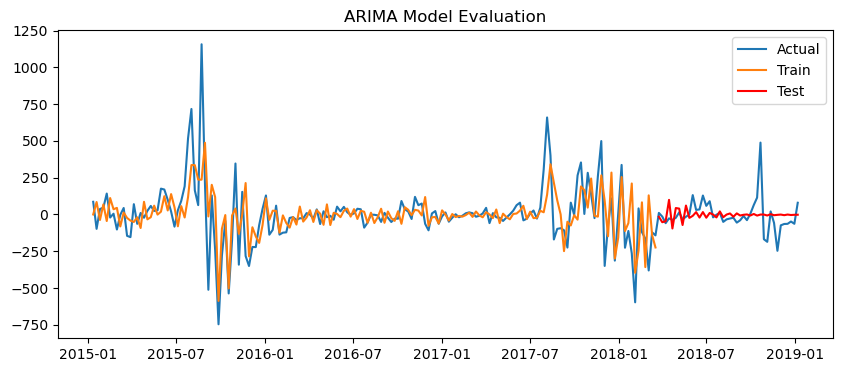

In [34]:
# Plot the train value and test value to evaluate the model
plt.figure(figsize=(10,4))
plt.plot(onion_diff['Modal'], label='Actual')
plt.plot(arima_fit.fittedvalues, label='Train')
plt.plot(predictions, color='red', label='Test')
plt.title('ARIMA Model Evaluation')
plt.legend()
plt.show()

In [35]:
# Forecast the rest 50 weeks
forecast_steps = 50
forecast_index = pd.date_range(onion1.index[-1], periods=forecast_steps, freq='W')
forecast = arima_fit.get_forecast(steps=forecast_steps, index=forecast_index)
forecast_diff = forecast.predicted_mean

# Get the last observed value from the original (non-differenced) data
last_value = onion1.iloc[-1]

# Reverse the diffencing
predicted_values = forecast_diff.cumsum() + last_value.iloc[0] # Get the scalar value

# Print the predicted values
print(predicted_values)

2019-01-06    570.408710
2019-01-13    517.737722
2019-01-20    471.445384
2019-01-27    570.624892
2019-02-03    475.313296
2019-02-10    518.940943
2019-02-17    558.765819
2019-02-24    486.902811
2019-03-03    547.525085
2019-03-10    524.172955
2019-03-17    514.778913
2019-03-24    530.830735
2019-03-31    509.748737
2019-04-07    525.980170
2019-04-14    503.968347
2019-04-21    514.168043
2019-04-28    513.538895
2019-05-05    493.304442
2019-05-12    514.119529
2019-05-19    495.400992
2019-05-26    494.867067
2019-06-02    501.686946
2019-06-09    486.299250
2019-06-16    493.498462
2019-06-23    486.379061
2019-06-30    484.188179
2019-07-07    484.187520
2019-07-14    476.895907
2019-07-21    480.249056
2019-07-28    472.675605
2019-08-04    472.032967
2019-08-11    471.482190
2019-08-18    464.366454
2019-08-25    466.384168
2019-09-01    461.320900
2019-09-08    458.706058
2019-09-15    457.971540
2019-09-22    453.073834
2019-09-29    452.505989
2019-10-06    448.750946


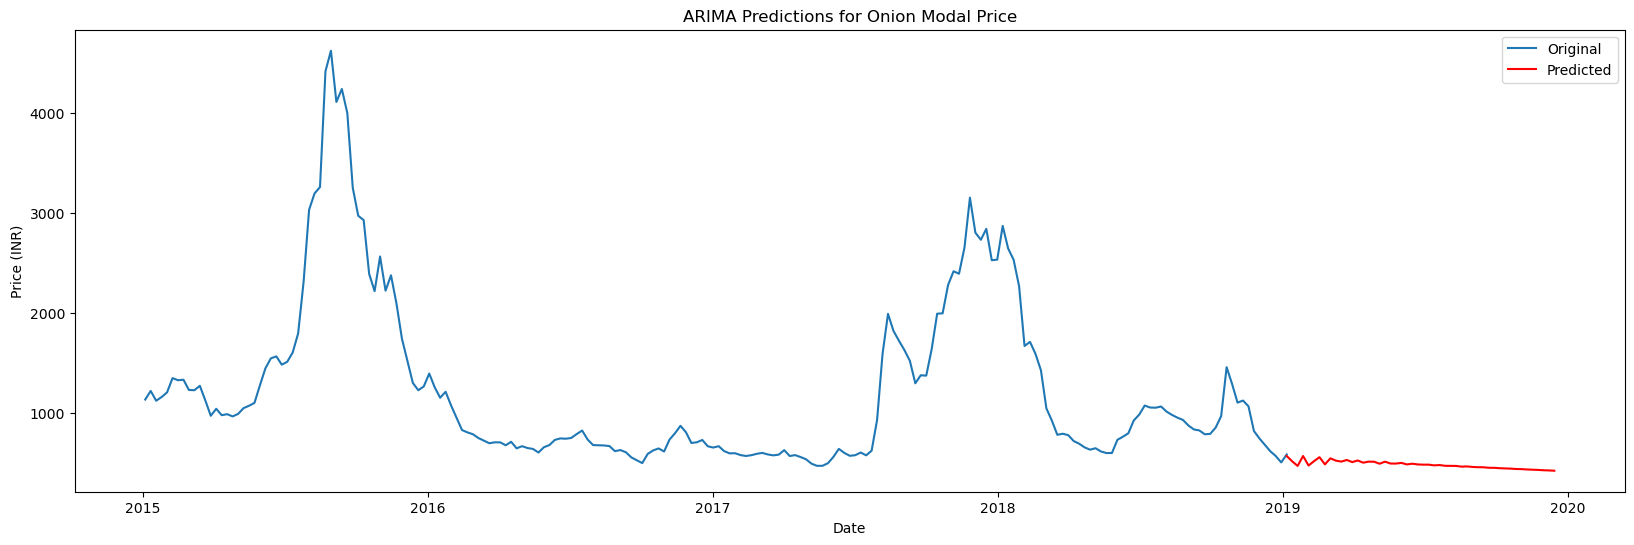

In [36]:
# Plot the original series
plt.figure(figsize=(20,6))
plt.plot(onion1['Modal'], label='Original')

# Plot the predicted values
plt.plot(predicted_values, color='red', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.title('ARIMA Predictions for Onion Modal Price')
plt.legend()
plt.show()

## Sarima

### 1 year seasonality

<Figure size 2000x600 with 0 Axes>

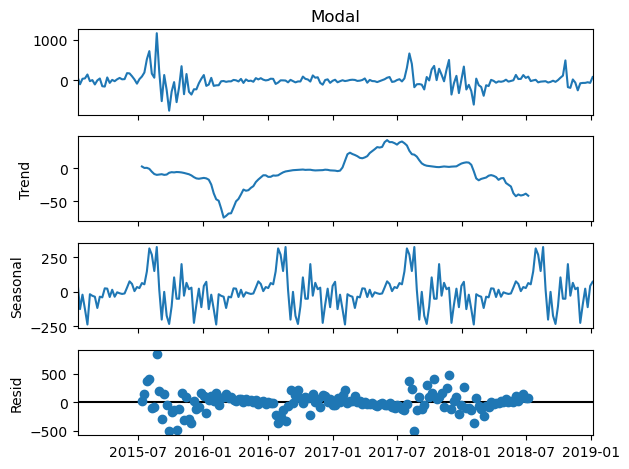

2015-01-11     71.775924
2015-01-18   -125.014827
2015-01-25    -20.913179
2015-02-01   -125.370596
2015-02-08   -235.851823
Freq: W-SUN, Name: seasonal, dtype: float64


In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
plt.figure(figsize=(20,6))
decomposition = seasonal_decompose(onion_diff['Modal'], model='additive', period=52)
decomposition.plot()
plt.show()

seasonal_values = decomposition.seasonal
print(seasonal_values.head())

In [38]:
train_size = int(len(onion_diff) * 0.8)
train, test = onion_diff[:train_size], onion_diff[train_size:]

In [39]:
p = 6
d = 1
q = 3
s = 52

In [40]:
seasonal_order = (p,d,q,s)
model_sarima = SARIMAX(train, order = (p,d,q), seasonal_order=seasonal_order)
model_sarima_fit = model_sarima.fit()
model_sarima_fit.summary()

C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Modal   No. Observations:                  167
Model:             SARIMAX(6, 1, 3)x(6, 1, 3, 52)   Log Likelihood                -771.305
Date:                            Thu, 05 Dec 2024   AIC                           1580.610
Time:                                    00:27:26   BIC                           1632.597
Sample:                                01-11-2015   HQIC                          1601.709
                                     - 03-18-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0911      0.161     -6.767      0.000      -1.407      -0.775
ar.L2         -0.4508      0.171     -2.630      0.009      -0.787      -0.115
ar.L3          0.5820      0.151      3.854      0.000       0.286       0.878
ar.L4          0.4017      0.135      2.968      0.003       0.136       0.667
ar.L5          0.0782      0.124      0.629      0.529      -0.166       0.322
ar.L6         -0.2224      0.106     -2.103      0.035      -0.430      -0.015
ma.L1          0.5060      4.237      0.119      0.905      -7.799       8.811
ma.L2         -0.5417      6.190     -0.087      0.930     -12.675      11.591
ma.L3         -0.9635      3.815     -0.253      0.801      -8.441       6.514
ar.S.L52      -0.0455   9033.846  -5.04e-06      1.000   -1.77e+04    1.77e+04
ar.S.L104      0.4060   3.34e+04   1.22e-05      1.000   -6.55e+04    6.55e+04
ar.S.L156      0.0816   1.35e+04   6.06e-06      1.000   -2.64e+04    2.64e+04
ar.S.L208      0.0474   5619.001   8.43e-06      1.000    -1.1e+04     1.1e+04
ar.S.L260      0.0084   5698.133   1.47e-06      1.000   -1.12e+04    1.12e+04
ar.S.L312     -0.0035   1.42e+04  -2.47e-07      1.000   -2.79e+04    2.79e+04
ma.S.L52      -0.0905   8156.243  -1.11e-05      1.000    -1.6e+04     1.6e+04
ma.S.L104     -0.2935   3.57e+04  -8.21e-06      1.000   -7.01e+04    7.01e+04
ma.S.L156      0.1997   1.53e+04    1.3e-05      1.000      -3e+04       3e+04
sigma2      3.831e+04     26.775   1430.901      0.000    3.83e+04    3.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                49.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.60
Prob(H) (two-sided):                  0.97   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+23. Standard errors may be unstable.
"""

In [41]:
predictions = model_sarima_fit.predict(start=test.index[0], end=test.index[-1])

In [42]:
rmse = np.sqrt(mean_squared_error(test['Modal'], predictions))
print('RMSE:', rmse)

mae = mean_absolute_error(test['Modal'], predictions)
print('MAE:', mae)

mape = mean_absolute_percentage_error(test['Modal'], predictions)
print('MAPE:', mape)

RMSE: 228.72308725282565
MAE: 159.95930593874283
MAPE: 4.8424942092628385


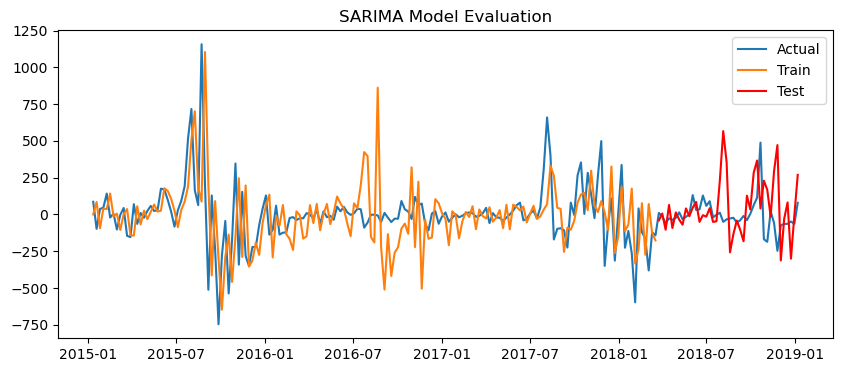

In [43]:
# Plot the train value and test value to evaluate the model
plt.figure(figsize=(10,4))
plt.plot(onion_diff['Modal'], label='Actual')
plt.plot(model_sarima_fit.fittedvalues, label='Train')
plt.plot(predictions, color='red', label='Test')
plt.title('SARIMA Model Evaluation')
plt.legend()
plt.show()

In [44]:
# Forecast the rest 100 weeks
forecast_steps = 100
forecast_index = pd.date_range(onion1.index[-1], periods=forecast_steps, freq='W')
forecast = model_sarima_fit.get_forecast(steps=forecast_steps, index=forecast_index)
forecast_diff = forecast.predicted_mean

# Get the last observed value from the original (non-differenced) data
last_value = onion1.iloc[-1]

# Reverse the diffencing
predicted_values = forecast_diff.cumsum() + last_value.iloc[0] # Get the scalar value

# Print the predicted values
print(predicted_values)

2019-01-06     545.673097
2019-01-13     552.174384
2019-01-20     448.154556
2019-01-27     512.505002
2019-02-03     420.514180
                 ...     
2020-11-01    2427.445134
2020-11-08    2146.242091
2020-11-15    1487.254839
2020-11-22    1538.905304
2020-11-29    1418.633867
Freq: W-SUN, Name: predicted_mean, Length: 100, dtype: float64


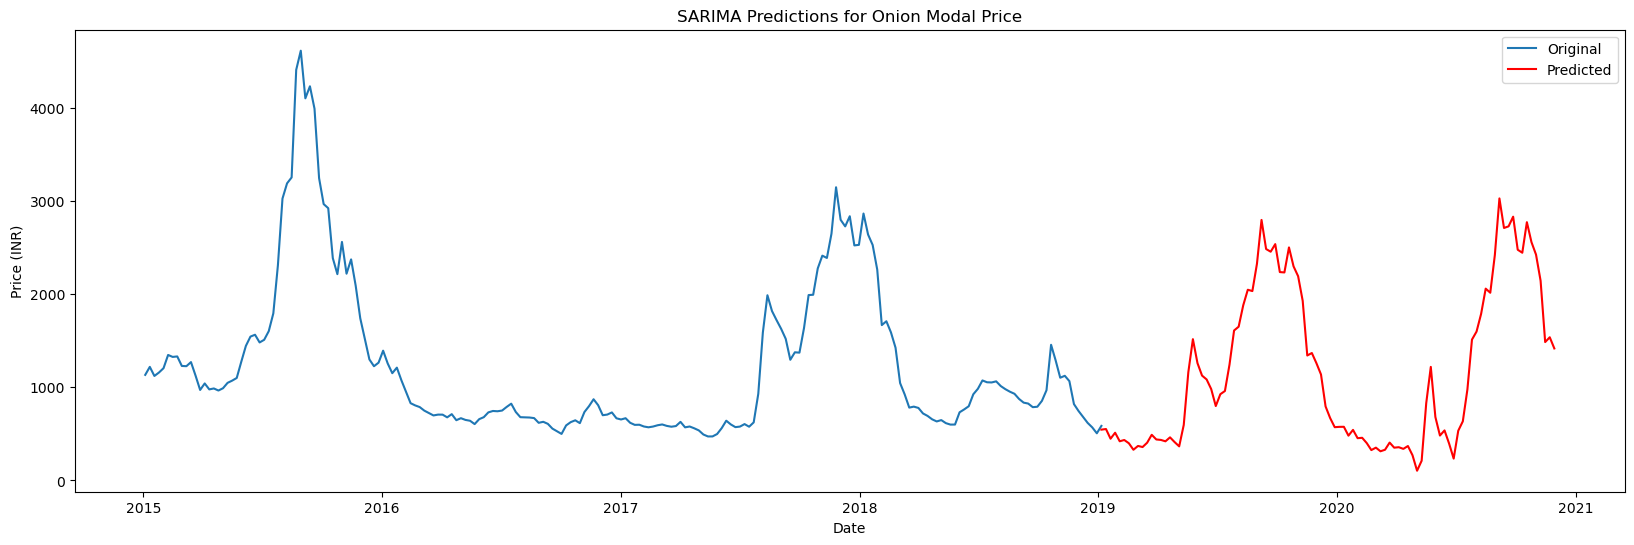

In [45]:
# Plot the original series
plt.figure(figsize=(20,6))
plt.plot(onion1['Modal'], label='Original')

# Plot the predicted values
plt.plot(predicted_values, color='red', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.title('SARIMA Predictions for Onion Modal Price')
plt.legend()
plt.show()

### 2 year seasonality

<Figure size 2000x600 with 0 Axes>

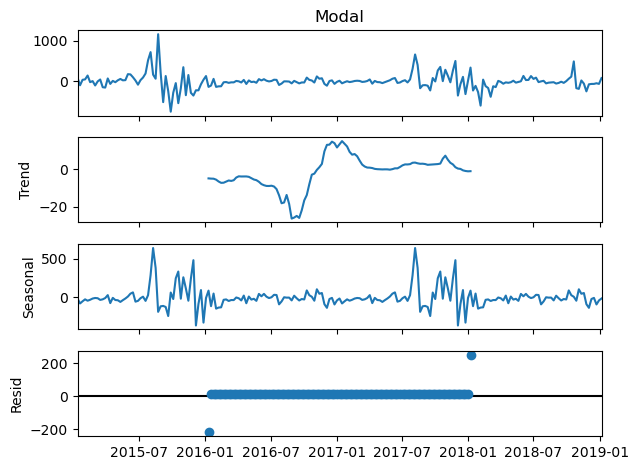

2015-01-11   -14.806928
2015-01-18   -79.074098
2015-01-25   -50.806928
2015-02-01   -25.654455
2015-02-08   -43.194977
Freq: W-SUN, Name: seasonal, dtype: float64


In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
plt.figure(figsize=(20,6))
decomposition = seasonal_decompose(onion_diff['Modal'], model='additive', period=104)
decomposition.plot()
plt.show()

seasonal_values = decomposition.seasonal
print(seasonal_values.head())

In [47]:
train_size = int(len(onion_diff) * 0.8)
train, test = onion_diff[:train_size], onion_diff[train_size:]

In [48]:
p = 6
d = 1
q = 3
s = 104

In [49]:
seasonal_order = (p,d,q,s)
model_sarima = SARIMAX(train, order = (p,d,q), seasonal_order=seasonal_order)
model_sarima_fit = model_sarima.fit()
model_sarima_fit.summary()

C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yihui\anaconda3\envs\tf-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Modal   No. Observations:                  167
Model:             SARIMAX(6, 1, 3)x(6, 1, 3, 104)   Log Likelihood                -435.972
Date:                             Thu, 05 Dec 2024   AIC                            909.943
Time:                                     01:12:51   BIC                            950.359
Sample:                                 01-11-2015   HQIC                           925.811
                                      - 03-18-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8577      0.750     -1.144      0.253      -2.328       0.612
ar.L2         -0.6519      0.528     -1.234      0.217      -1.688       0.384
ar.L3          0.4014      0.456      0.881      0.378      -0.492       1.295
ar.L4          0.3280      0.537      0.611      0.541      -0.725       1.381
ar.L5          0.2741      0.436      0.629      0.529      -0.580       1.128
ar.L6          0.0890      0.315      0.283      0.778      -0.528       0.706
ma.L1          0.3017      1.766      0.171      0.864      -3.159       3.762
ma.L2         -0.3765      1.868     -0.202      0.840      -4.038       3.285
ma.L3         -0.9148      1.536     -0.596      0.551      -3.925       2.096
ar.S.L104     -0.1229   5.11e+05   -2.4e-07      1.000      -1e+06       1e+06
ar.S.L208      0.0505   2.81e+05    1.8e-07      1.000   -5.51e+05    5.51e+05
ar.S.L312     -0.0155    2.7e+05  -5.74e-08      1.000    -5.3e+05     5.3e+05
ar.S.L416     -0.0031   1.27e+05  -2.42e-08      1.000   -2.49e+05    2.49e+05
ar.S.L520   1.439e-05   5.31e+05   2.71e-11      1.000   -1.04e+06    1.04e+06
ar.S.L624   4.619e-06   9.32e+05   4.95e-12      1.000   -1.83e+06    1.83e+06
ma.S.L104     -0.1221   5.12e+05  -2.39e-07      1.000      -1e+06       1e+06
ma.S.L208     -0.0205   3.65e+05   -5.6e-08      1.000   -7.16e+05    7.16e+05
ma.S.L312      0.0201   2.46e+05   8.19e-08      1.000   -4.82e+05    4.82e+05
sigma2      9.168e+04   1114.214     82.283      0.000    8.95e+04    9.39e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                50.40
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              12.10   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+22. Standard errors may be unstable.
"""

In [50]:
predictions = model_sarima_fit.predict(start=test.index[0], end=test.index[-1])

In [51]:
rmse = np.sqrt(mean_squared_error(test['Modal'], predictions))
print('RMSE:', rmse)

mae = mean_absolute_error(test['Modal'], predictions)
print('MAE:', mae)

mape = mean_absolute_percentage_error(test['Modal'], predictions)
print('MAPE:', mape)

RMSE: 135.35221704887482
MAE: 95.95151457001643
MAPE: 11.620948734765632


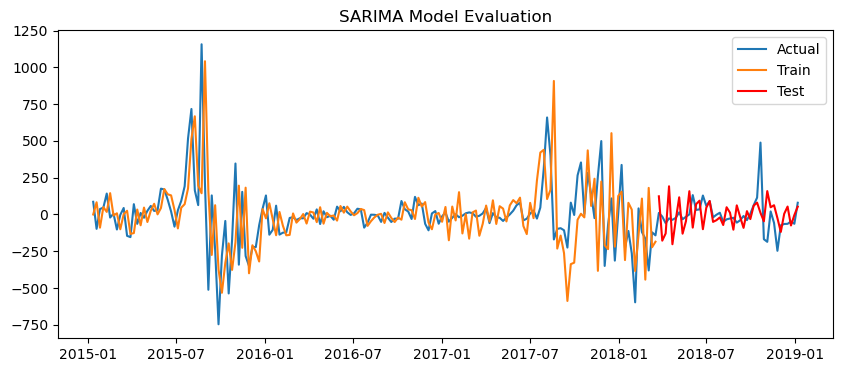

In [52]:
# Plot the train value and test value to evaluate the model
plt.figure(figsize=(10,4))
plt.plot(onion_diff['Modal'], label='Actual')
plt.plot(model_sarima_fit.fittedvalues, label='Train')
plt.plot(predictions, color='red', label='Test')
plt.title('SARIMA Model Evaluation')
plt.legend()
plt.show()

In [53]:
# Forecast the rest 100 weeks
forecast_steps = 100
forecast_index = pd.date_range(onion1.index[-1], periods=forecast_steps, freq='W')
forecast = model_sarima_fit.get_forecast(steps=forecast_steps, index=forecast_index)
forecast_diff = forecast.predicted_mean

# Get the last observed value from the original (non-differenced) data
last_value = onion1.iloc[-1]

# Reverse the diffencing
predicted_values = forecast_diff.cumsum() + last_value.iloc[0] # Get the scalar value

# Print the predicted values
print(predicted_values)

2019-01-06     709.335121
2019-01-13     531.280462
2019-01-20     402.012678
2019-01-27     593.583710
2019-02-03     391.208642
                 ...     
2020-11-01    2213.375740
2020-11-08    1986.246894
2020-11-15    1509.336372
2020-11-22    1515.624592
2020-11-29    1425.230301
Freq: W-SUN, Name: predicted_mean, Length: 100, dtype: float64


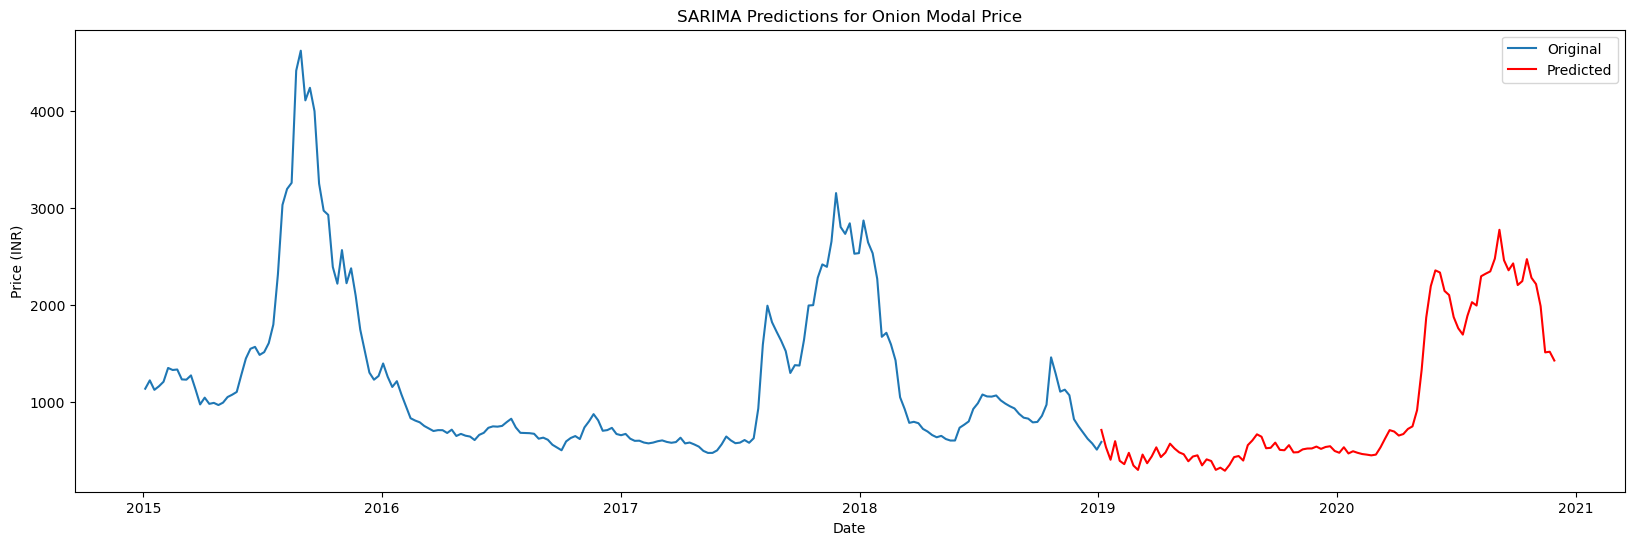

In [54]:
# Plot the original series
plt.figure(figsize=(20,6))
plt.plot(onion1['Modal'], label='Original')

# Plot the predicted values
plt.plot(predicted_values, color='red', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.title('SARIMA Predictions for Onion Modal Price')
plt.legend()
plt.show()